In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
# -*- coding: utf-8 -*-
"""
Streamlined Model 4 with optional Optuna hyper‑parameter tuning
==============================================================
• Set **tuning = True** below to run an Optuna search first.
  – After the search the script trains a final model with the *best* params
    for the full number of epochs and proceeds exactly as before.
• Set **tuning = False** to skip the search and use default hyper‑parameters.
"""

# -----------------------------------------------------------------------------
# 0.  User switch ─ set to True to enable hyper‑parameter tuning
# -----------------------------------------------------------------------------
tuning = False # True

# -----------------------------------------------------------------------------
# 1. Imports & basic setup
# -----------------------------------------------------------------------------
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

if tuning:
    import optuna

plt.style.use("ggplot")


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

# -----------------------------------------------------------------------------
# 2. File locations
# -----------------------------------------------------------------------------
BASE_DIR = "/content/drive/MyDrive/Calibration_ABM"
INCIDENCE_CSV = os.path.join(BASE_DIR, "incidence.csv 1.gz")
THETA_CSV     = os.path.join(BASE_DIR, "theta.csv 1.gz")
OUTPUT_DIR    = os.path.join(BASE_DIR, "model_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [5]:

# -----------------------------------------------------------------------------
# 3. Load & preprocess data (same as before)
# -----------------------------------------------------------------------------
print("Loading data …")
incidence_df = pd.read_csv(INCIDENCE_CSV)
theta_df_og  = pd.read_csv(THETA_CSV)
theta_df_og

Loading data …


,n,preval,crate,recov,R0,ptran
0,7339,0.011854,3.656652,0.114097,3.448820,0.107612
1,5037,0.019456,4.986954,0.163861,3.967869,0.130376
2,8782,0.003644,4.783897,0.176841,4.540546,0.167845
3,6062,0.005279,2.671758,0.078053,4.754054,0.138886
4,5196,0.014242,2.624002,0.073319,3.714819,0.103799
...,...,...,...,...,...,...
59981,9042,0.001106,3.935369,0.085228,3.027612,0.065569
59982,5185,0.002507,4.858669,0.079285,3.856799,0.062936
59983,6987,0.005868,3.022589,0.136060,1.516984,0.068286
59984,5386,0.015410,4.612202,0.113495,3.027793,0.074507


In [6]:

additional_cols = ["n", "recov"]
additional_raw  = theta_df_og[additional_cols].values
target_cols     = ["ptran", "crate", "R0"]
targets_raw     = theta_df_og[target_cols].values

scaler_incidence  = MinMaxScaler()
scaler_additional = MinMaxScaler()
scaler_targets    = MinMaxScaler()

X_inc = scaler_incidence.fit_transform(incidence_df)
X_inc = X_inc.reshape(-1, incidence_df.shape[1], 1)  # (N, T, 1)
add_inputs = scaler_additional.fit_transform(additional_raw)
Y_targets  = scaler_targets.fit_transform(targets_raw)

X_train, X_val, add_train, add_val, y_train, y_val = train_test_split(
    X_inc, add_inputs, Y_targets, test_size=0.2, random_state=42, shuffle=True
)

# PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
add_train_t = torch.tensor(add_train, dtype=torch.float32)
add_val_t   = torch.tensor(add_val,   dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)

BATCH_SIZE = 64
train_ds = torch.utils.data.TensorDataset(X_train_t, add_train_t, y_train_t)
val_ds   = torch.utils.data.TensorDataset(X_val_t,   add_val_t,   y_val_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)


In [7]:

# -----------------------------------------------------------------------------
# 4. Model definition
# -----------------------------------------------------------------------------
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int,
                 additional_dim: int, output_dim: int, dropout: float):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(2 * hidden_dim + additional_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid  = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, x, add_inputs):
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = torch.relu(self.fc1(torch.cat((h, add_inputs), dim=1)))
        out = self.fc2(h)
        out = torch.stack([
            self.sigmoid(out[:, 0]),
            self.softplus(out[:, 1]),
            self.softplus(out[:, 2]),
        ], dim=1)
        return out


In [8]:

# -----------------------------------------------------------------------------
# 5. Loss function
# -----------------------------------------------------------------------------

def penalized_loss(y_pred, y_true, add_inputs, lambda_penalty: float):
    mse = nn.functional.mse_loss(y_pred, y_true)
    ptran_p, crate_p, R0_p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    recov = add_inputs[:, 1]
    penalty = nn.functional.mse_loss(R0_p * recov, ptran_p * crate_p)
    return mse + lambda_penalty * penalty



In [9]:

# -----------------------------------------------------------------------------
# 6. Helper: training for a fixed set of hyper‑parameters
# -----------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

def train_eval(params: dict, max_epochs: int, quiet: bool = False):
    model = BiLSTMModel(
        input_dim=1,
        hidden_dim=params["hidden_dim"],
        num_layers=params["num_layers"],
        additional_dim=2,
        output_dim=3,
        dropout=params["dropout"],
    ).to(DEVICE)
    optimiser = optim.Adam(model.parameters(), lr=params["lr"])
    lambda_pen = params["lambda_penalty"]

    for epoch in range(max_epochs):
        model.train()
        for Xb, add_b, yb in train_loader:
            Xb, add_b, yb = Xb.to(DEVICE), add_b.to(DEVICE), yb.to(DEVICE)
            optimiser.zero_grad()
            loss = penalized_loss(model(Xb, add_b), yb, add_b, lambda_pen)
            loss.backward()
            optimiser.step()

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, add_b, yb in val_loader:
            Xb, add_b, yb = Xb.to(DEVICE), add_b.to(DEVICE), yb.to(DEVICE)
            val_loss += penalized_loss(model(Xb, add_b), yb, add_b, lambda_pen).item() * Xb.size(0)
    val_loss /= len(val_loader.dataset)

    if not quiet:
        print(f"Validation loss: {val_loss:.4f}")
    return val_loss, model



In [10]:

# -----------------------------------------------------------------------------
# 7. Optuna tuning (optional)
# -----------------------------------------------------------------------------
DEFAULT_PARAMS = {
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.3,
    "lr": 1e-3,
    "lambda_penalty": 0.03,
}
OPTUNA_OPTIMAL_PARAMS = {
    'hidden_dim': 160,
    'num_layers': 3,
    'dropout': 0.5,
    'lr': 0.0002766923888203664,
    'lambda_penalty': 0.0001773491932427762}

if tuning:
    print("\n⚙️  Hyper‑parameter tuning with Optuna …")

    def objective(trial):
        params = {
            "hidden_dim": trial.suggest_int("hidden_dim", 64, 256, step=32),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "dropout": trial.suggest_float("dropout", 0.1, 0.5, step=0.05),
            "lr": trial.suggest_float("lr", 1e-4, 3e-3, log=True),
            "lambda_penalty": trial.suggest_float("lambda_penalty", 0.0, 0.3, log=False)
        }
        val_loss, _ = train_eval(params, max_epochs=30, quiet=True)
        return val_loss

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40, timeout=60 * 30)
    print("Best params:", study.best_trial.params)
    BEST_PARAMS = study.best_trial.params
else:
    #BEST_PARAMS = DEFAULT_PARAMS
    BEST_PARAMS = OPTUNA_OPTIMAL_PARAMS

# -----------------------------------------------------------------------------
# 8. Final training with best params (full epochs)
# -----------------------------------------------------------------------------
print("\nTraining final model …")
FINAL_EPOCHS = 100
_, final_model = train_eval(BEST_PARAMS, FINAL_EPOCHS)



Training final model …
Validation loss: 0.0291


Evaluating final model …

Mean Absolute Error (original units):
  ptran: 0.0555
  crate: 0.9800
  R0   : 0.0653


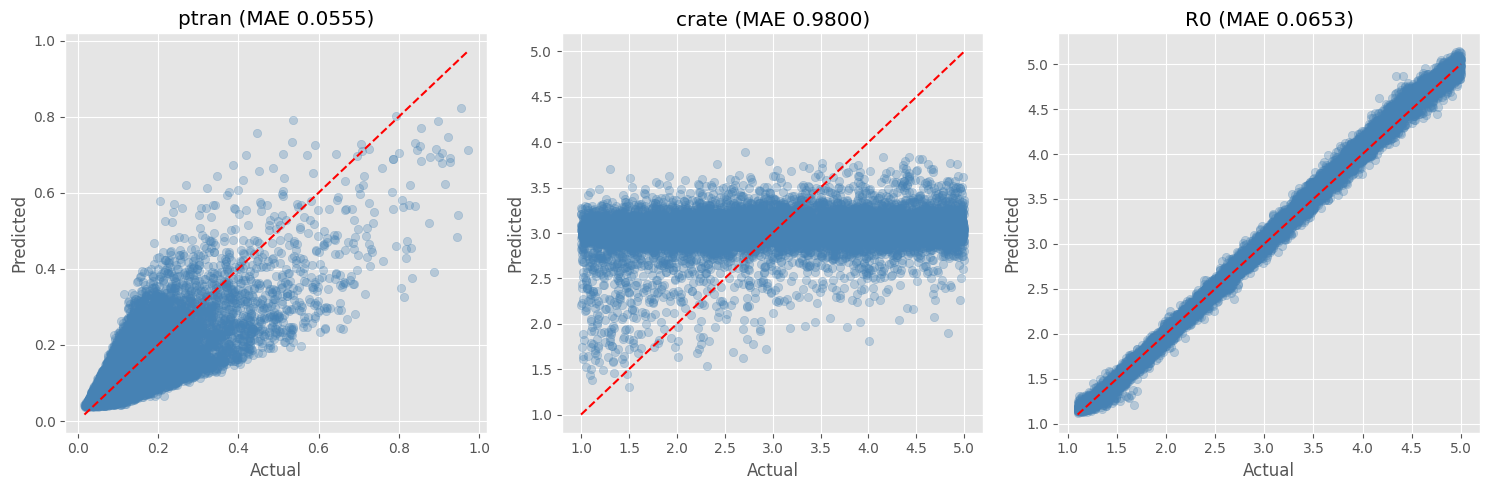

Saving final model & scalers …
Done → /content/drive/MyDrive/Calibration_ABM/model_output


In [11]:
# -----------------------------------------------------------------------------
# 9. Evaluation in original units + plots
# -----------------------------------------------------------------------------
print("Evaluating final model …")
final_model.eval()
with torch.no_grad():
    preds, trues = [], []
    for Xb, add_b, yb in val_loader:
        preds.append(final_model(Xb.to(DEVICE), add_b.to(DEVICE)).cpu().numpy())
        trues.append(yb.cpu().numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

preds_orig = scaler_targets.inverse_transform(preds)
trues_orig = scaler_targets.inverse_transform(trues)
mae_vals = [mean_absolute_error(trues_orig[:, i], preds_orig[:, i]) for i in range(3)]
print("\nMean Absolute Error (original units):")
for col, mae in zip(target_cols, mae_vals):
    print(f"  {col:5s}: {mae:.4f}")

plt.figure(figsize=(15, 5))
for i, col in enumerate(target_cols):
    ax = plt.subplot(1, 3, i + 1)
    ax.scatter(trues_orig[:, i], preds_orig[:, i], color="steelblue", alpha=0.3)
    lims = [trues_orig[:, i].min(), trues_orig[:, i].max()]
    ax.plot(lims, lims, "r--")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{col} (MAE {mae_vals[i]:.4f})")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 10. Persist model & scalers
# -----------------------------------------------------------------------------
print("Saving final model & scalers …")
torch.save(final_model.state_dict(), os.path.join(OUTPUT_DIR, "model4_bilstm.pt"))
joblib.dump(scaler_additional, os.path.join(OUTPUT_DIR, "scaler_additional.pkl"))
joblib.dump(scaler_targets,    os.path.join(OUTPUT_DIR, "scaler_targets.pkl"))
joblib.dump(scaler_incidence, os.path.join(OUTPUT_DIR, "scaler_incidence.pkl"))

print("Done →", OUTPUT_DIR)